Let's build an end-to-end classifier that helps classify Wikipedia comments.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from pylab import *
import nltk
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score,roc_curve,classification_report,confusion_matrix,precision_recall_curve,auc

In this step, we will read a data file. It has two columns: comment_text and
toxic. The comment_text column contains various user comments and the toxic
column contains their corresponding labels. Here, label 0 denotes that a comment
is not toxic and label 1 denotes that a comment is toxic.

In [3]:
data = pd.read_csv('dataset/train_comment_small.csv')
data.head()

,comment_text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


We'll now create a generic function for all classifiers, called clf_model. It takes
four inputs: type of model, features of the training dataset, labels of the training
dataset, and features of the validation dataset. It returns predicted labels,
predicted probabilities, and the model it has been trained on.

In [4]:
def clf_model(model_type, X_train, y_train, X_valid):
    model = model_type.fit(X_train,y_train)
    predicted_labels = model.predict(X_valid)
    predicted_probab = model.predict_proba(X_valid)[:,1]
    return [predicted_labels,predicted_probab, model]

Furthermore, another function is defined, called model_evaluation. It takes three
inputs: actual values, predicted values, and predicted probabilities. It prints a
confusion matrix, accuracy, f1-score, precision, recall scores, and area under the
ROC curve. It also plots the ROC curve:

In [5]:
def model_evaluation(actual_values, predicted_values, predicted_probabilities):
    cfn_mat = confusion_matrix(actual_values,predicted_values)
    print("confusion matrix: \n",cfn_mat)
    print("\naccuracy: ",accuracy_score(actual_values,predicted_values))
    print("\nclassification report: \n", classification_report(actual_values,predicted_values))
    fpr,tpr,threshold=roc_curve(actual_values, predicted_probabilities)
    print ('\nArea under ROC curve for validation set:', auc(fpr,tpr))
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(fpr,tpr,label='Validation set AUC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    ax.legend(loc='best')
    plt.show()

In this step, we'll use a lambda function to extract tokens from each text in this
DataFrame (called data), check whether any of these tokens are stop words,
lemmatize them, and concatenate them side by side. We'll use the join function
to concatenate a list of words into a single sentence. We'll use a regular expression
(re) to replace anything other than letters, digits, and white spaces with blank
space.

In [6]:
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')
stop_words = stop_words + list(string.printable)
data['cleaned_comment_text'] = data['comment_text'].apply(\
lambda x : ' '.join([lemmatizer.lemmatize(word.lower()) \
    for word in word_tokenize(re.sub(r'([^\s\w]|_)+', ' ', str(x))) if
    word.lower() not in stop_words]))

Now, we'll create a tf-idf matrix representation of these cleaned texts.

In [11]:
tfidf_model = TfidfVectorizer(max_features=500)
tfidf_df = pd.DataFrame(tfidf_model.fit_transform(data['cleaned_comment_text']).todense())
tfidf_df.columns = sorted(tfidf_model.vocabulary_)
tfidf_df.head()

,10,100,11,12,20,2005,2006,2007,2008,24,...,wp,write,writing,written,wrong,wrote,www,year,yes,yet
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.537393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Use sklearn's train_test_split function to divide the dataset into training and
validation sets.

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(tfidf_df,
data['toxic'], test_size=0.2, random_state=42,stratify = data['toxic'])

Here, we'll train a logistic regression model using sklearn's LogisticRegression()
function and evaluate it for the validation set.

confusion matrix: 
 [[28677   179]
 [ 1733  1326]]

accuracy:  0.9400908663637788

classification report: 
               precision    recall  f1-score   support

           0       0.94      0.99      0.97     28856
           1       0.88      0.43      0.58      3059

    accuracy                           0.94     31915
   macro avg       0.91      0.71      0.77     31915
weighted avg       0.94      0.94      0.93     31915


Area under ROC curve for validation set: 0.9051937836448741


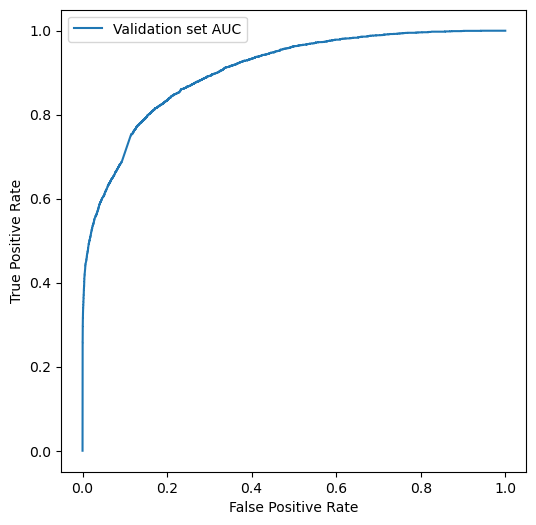

In [13]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
results = clf_model(logreg, X_train, y_train, X_valid)
model_evaluation(y_valid, results[0], results[1])

# Random Forest Classifier

We'll train a random forest model using sklearn's RandomForestClassifier() function
and evaluate it for the validation set.

confusion matrix: 
 [[28856     0]
 [ 2990    69]]

accuracy:  0.9063136456211812

classification report: 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95     28856
           1       1.00      0.02      0.04      3059

    accuracy                           0.91     31915
   macro avg       0.95      0.51      0.50     31915
weighted avg       0.92      0.91      0.86     31915


Area under ROC curve for validation set: 0.8531297215658813


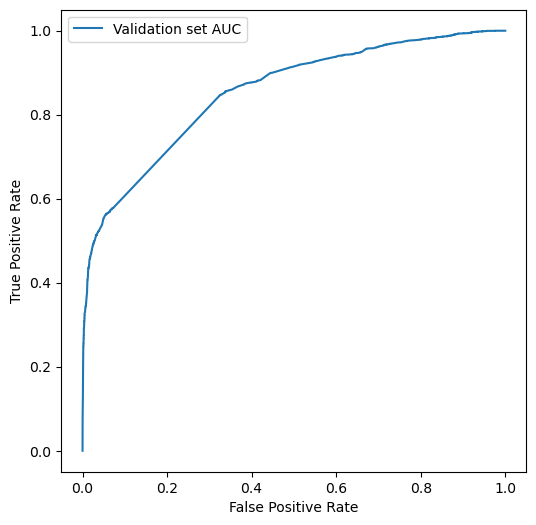

In [14]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=20,max_depth=4,max_features='sqrt',random_state=1)
results = clf_model(rfc, X_train, y_train, X_valid)
model_evaluation(y_valid, results[0], results[1])
model_rfc = results[2]

Moreover, we extract important features, which are the tokens or words that play
a more vital role in determining whether a comment will be toxic.

In [15]:
word_importances = pd.DataFrame({'word':X_train.
columns,'importance':model_rfc.feature_importances_})
word_importances.sort_values('importance', ascending = False).head(4)

,word,importance
455,unpleasant,0.190242
49,awful,0.179852
42,as,0.160197
280,nightmare,0.047444


# XGBoost Classifier

We train an XGBoost model using the XGBClassifier() function and evaluate it for
the validation set.

confusion matrix: 
 [[28757    99]
 [ 1987  1072]]

accuracy:  0.9346388845370516

classification report: 
               precision    recall  f1-score   support

           0       0.94      1.00      0.96     28856
           1       0.92      0.35      0.51      3059

    accuracy                           0.93     31915
   macro avg       0.93      0.67      0.74     31915
weighted avg       0.93      0.93      0.92     31915


Area under ROC curve for validation set: 0.7735450847771302


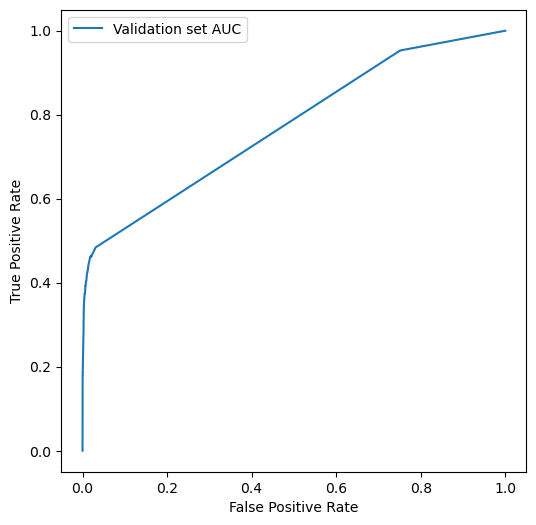

In [17]:
from xgboost import XGBClassifier
xgb_clf=XGBClassifier(n_estimators=20,learning_rate=0.03,max_depth=5,subsample=0.6,colsample_bytree= 0.6,reg_alpha= 10,seed=42)
results = clf_model(xgb_clf, X_train, y_train, X_valid)
model_evaluation(y_valid, results[0], results[1])
model_xgb = results[2]

Moreover, we extract the importance of features, that is, tokens or words that play
a more vital role in determining whether a comment is toxic.